In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']
plt.rcParams['font.size'] = 12

In [2]:
import gait
import utils
from gait import renyi_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel
from gait import test_mixture_divergence, renyi_mixture_divergence_stable
from gait import renyi_mixture_divergence, renyi_sim_divergence, renyi_sim_divergence_stable
from gait import breg_mixture_divergence_stable, breg_sim_divergence_stable
from gait import breg_mixture_divergence, breg_sim_divergence

In [3]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
#             self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.ReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [4]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 2, [500, 500]
batch_size_p = 200
batch_size_q = 200

In [5]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [6]:
alpha = 1
sigma_mult = 1

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs_p = torch.ones(1, batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(1, batch_size_q).cuda()/batch_size_q

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2 * sigma_mult], log=True))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

D = lambda x, y: breg_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, symmetric=False)

# D = lambda x, y: renyi_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, alpha,
#                                                  use_avg=False, use_full=False, symmetric=True)
# D = lambda x, y: test_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel,
#                                          symmetric=True, use_avg=False)

In [7]:
# for g in g_optimizer.param_groups:
#     g['lr'] = 1e-4

for _ in range(50000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

#         x = x_real[:batch_size//2]
#         x_prime = x_real[batch_size//2:]
#         y = x_fake[:batch_size//2]
#         y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)

        loss = D(x_real, x_fake)
#         loss = D(x_fake, x_real)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 13.9981
200 - 0.6382
400 - 0.3631
600 - 0.3934
800 - 0.3738
1000 - 0.3196
1200 - 0.1488
1400 - 0.2395
1600 - 0.2924
1800 - 0.2549
2000 - 0.2633
2200 - 0.2692
2400 - 0.2586
2600 - 0.2877
2800 - 0.2050
3000 - 0.1875
3200 - 0.2751
3400 - 0.2241
3600 - 0.2868
3800 - 0.2194
4000 - 0.1518
4200 - 0.2911
4400 - 0.1658
4600 - 0.2354
4800 - 0.1664
5000 - 0.1960
5200 - 0.2201
5400 - 0.1743
5600 - 0.1775
5800 - 0.1818
6000 - 0.1848
6200 - 0.1875
6400 - 0.2487
6600 - 0.1637
6800 - 0.1560
7000 - 0.2300
7200 - 0.2163
7400 - 0.2041
7600 - 0.2136
7800 - 0.2642
8000 - 0.1647
8200 - 0.2020
8400 - 0.2004
8600 - 0.1914
8800 - 0.1626
9000 - 0.2667
9200 - 0.2073
9400 - 0.2000
9600 - 0.2161
9800 - 0.1971
10000 - 0.1574
10200 - 0.2464
10400 - 0.2022
10600 - 0.1499
10800 - 0.2182
11000 - 0.3540
11200 - 0.1996
11400 - 0.1818
11600 - 0.1049
11800 - 0.2740
12000 - 0.2245
12200 - 0.2341
12400 - 0.1377
12600 - 0.1447
12800 - 0.2296
13000 - 0.1791
13200 - 0.2110
13400 - 0.1952
13600 - 0.1500
13800 - 0.1853
14000 

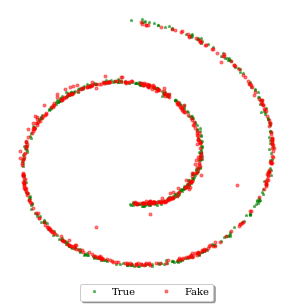

In [36]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.00), fancybox=True, shadow=True, ncol=2);

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

cur_axes.spines['top'].set_visible(False)
cur_axes.spines['right'].set_visible(False)
cur_axes.spines['bottom'].set_visible(False)
cur_axes.spines['left'].set_visible(False)

# plt.show()
plt.savefig('swiss_roll.pdf', dpi=100)